In [1]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
#from scipy.stats import boxcox
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
import math
from sklearn import metrics


from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
from sklearn.model_selection import GridSearchCV


from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics



plt.style.use('ggplot') 
%matplotlib inline

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).


# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis. The query was exported from Porticoto the file ADMISSIONS_ICUSTAY_SEPSIS.csv. The data was read into a pandas dataframe ptnt_demog 



## INTEGRATE DATA FROM LABS AND CHARTS
Data from labs and charts have been previously aggregated and summarized (variables with multiple measurements have had mean, std, skewness etc calculated). Data is integrated/merged into a single data_frame. 

## FEATURE SELECTION
Feature selection tools, including SelectKBest, require data sets to be full (no NaN values)and to be of the same type (continuous/categorical). To reduce the dimensionality of our data and select the most relevant features, data is then broken out into blocks according to data type. Because not all data was collected for all icu stays or patients there are gaps such that there are very few icu stays for which there are no NaN values. There were patterns of data collection however, groups of variables that were most often collected together (likely the results of the condition, the type of ICU etc). To generate full sets of data for feature selection, the data is further broken down into blocks of variables most often collected together. 

In [2]:
features_dir = os.getcwd() + '/features/'
#display(features_dir)
monkey = os.listdir(features_dir)
feature_files = [x for x in monkey if '.csv' in x]
#display(feature_files )
features_dict = {}
for name in feature_files:
    features_dict[name.split('.')[0]] = pd.DataFrame.from_csv(features_dir + name)
outcomes = pd.DataFrame.from_csv(features_dir + 'outcomes.csv')

scores = [x for x in features_dict.keys() if 'Scores' in x]
features = [x for x in features_dict.keys() if 'Scores' not in x]
scores.sort()
features.sort()
#display(scores)
#display(features)

for i in range(len(scores)):
    if i == 0:
        all_scores = features_dict[scores[i]]
    else:
        all_scores = all_scores.append(features_dict[scores[i]])


all_scores = all_scores.sort_values(by = 'p_values', ascending = True)
top_scores = list(all_scores.head(20).index)


first = True
all_data = outcomes
for frame in features:
    for col in features_dict[frame].columns:
        if col in top_scores:
            
            feat = features_dict[frame][col] 
            all_data = all_data.merge(pd.DataFrame(feat), left_index = True, 
                                     right_index = True, how = 'inner', sort = True)
            
            #display(feat.name)
            #display(all_data.shape)

display(all_data.head())
           

,hospital_expire_flag,GCS Total_15,GCS Total_3,GCS Total_6,GCS Total_4,RR_mean_Q3,Creat_abnflag,Respiratory failure; insufficiency; arrest (adult),Shock,Septicemia (except in labor),...,icu_stay_Q3,Other liver diseases,first_careunit_CSRU,Fluid and electrolyte disorders,admission_type_ELECTIVE,Pneumonia (except that caused by tuberculosis or sexually transmitted disease),Acute cerebrovascular disease,icu_stay_Q0,age_Q3,first_careunit_MICU
icustay_id,,,,,,,,,,,,,,,,,,,,,
294638,0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,1,...,0.0,1,0.0,1,0.0,0,0,1.0,0.0,1.0
217847,0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0,...,1.0,0,0.0,0,0.0,0,0,0.0,1.0,0.0
211200,0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0,...,1.0,0,1.0,0,0.0,0,0,0.0,0.0,0.0
248910,0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,1,...,1.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0
249195,0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0,...,0.0,0,1.0,0,1.0,0,0,1.0,1.0,0.0


Evaluating SVC
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
ANALYSIS COMPLETE


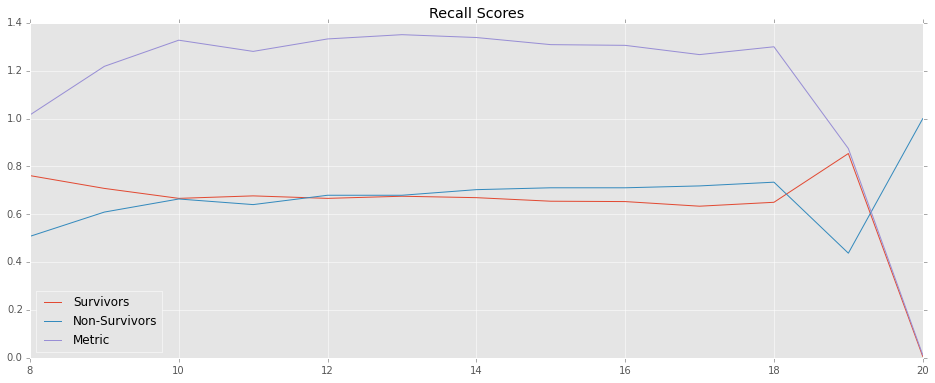

Optimized Parameters for the SVC Classifier for recall are
{'kernel': 'rbf', 'C': 0.7, 'features': 13, 'degree': 2, 'decision_function_shape': 'ovr', 'class_weight': {0: 1, 1: 5}}
optimized Scores are
             precision    recall  f1-score   support

          0       0.92      0.68      0.78       672
          1       0.29      0.68      0.40       128

avg / total       0.82      0.68      0.72       800



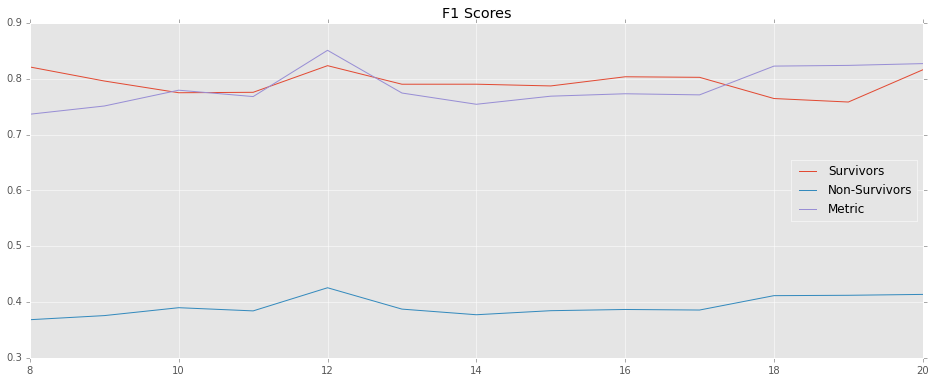

Optimized Parameters for the SVC Classifier for f1_score are
{'kernel': 'sigmoid', 'C': 0.8, 'features': 12, 'degree': 2, 'decision_function_shape': 'ovr', 'class_weight': {0: 1, 1: 5}}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.91      0.75      0.82       672
          1       0.32      0.62      0.43       128

avg / total       0.82      0.73      0.76       800



In [73]:
# THE SUPPORT VECTOR CLASSIFIER IS OPTIMZED TO TO F1-SCORE AND RECALL OVER THE GIVEN PARAMETER SPACE
# AND OVER THE NUMBER OF FEATURES USING THE TOP 20 FEATURES RANKED ACCORDING TO CHI2 SCORE
# RECALL FOR MORTALITY PREDICTION IS IMPORTANT IN THAT WE DON'T WANT FALSE NEGATIVES. 
# THE SUPPORT VECTOR CLASSIFIER TAKES A VERY LONG TIME TO OPTIMIZE OVER THE GIVEN PARAMETER SPACE SO 
# THAT IS BEING DONE INDIVIDUALLY HERE. THE REMAINING CLASSIFIERS ARE OPTIMIZED BELOW

optimized_clfs = {}

#LinearSVC CLASSIFIER PARAMETERES
SVC_params = {'C':[0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9,1],  
               'class_weight': [{1:3, 0:1}, {1:4, 0:1}, {1:5, 0:1}],
               'kernel': ['rbf', 'poly', 'sigmoid'], 
               'degree': [2,3,4], 
               'decision_function_shape': ['ovr', 'ovo']
                                
              }


# CLASSIFIER SCORES
scores = ['f1', 'recall'] #'accuracy', , 'precision']

# DICTIONARY OF CLASSIFIERS AND CORRESPONDING PARAMETERS 
SVC = svm.SVC(random_state = 42)
SVC_stuff = [SVC, SVC_params]

classifiers = {
               'SVC' : SVC_stuff
              }
               


for key in classifiers.keys():
    
    recall_mortality = 0
    f1_mortality = 0
    optimized_params = {}
    optimized = {}
    optimized_scores = ""
    recall_scores = {}
    f1_scores = {}

    print "Evaluating {}".format(key)
    for num_feats in range(8, all_data.shape[1]):
        print "{} features".format(num_feats)
        # FEATURES AND TARGETS
        X_best = all_data[all_data.columns[1:num_feats]]
        y = all_data['hospital_expire_flag']

        X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.30, random_state = 42)
        
        
        # MAY NOT BE NECESSARY THE WAY THE CODE IS CURRENTLY BROKEN OUT
        for score in scores:
            #print"# Optimizing parameters for {} classifier to {} score using {} features".format(key, score, num_feats)

         
            clf = GridSearchCV(classifiers[key][0], classifiers[key][1], cv = 5, 
                           scoring = score)

            clf.fit(X_train, y_train)
    
            y_true, y_pred = y_test, clf.predict(X_test)
            scores_report = metrics.classification_report(y_true, y_pred)
            
            
            #print(clf.best_params_)
            #print(scores_report)
         
            if score == 'recall':
                surv, mort = metrics.recall_score(y_true, y_pred, average = None)
                # a metric that maximizes both variables and minimizes the difference between them
                recall_metric = mort + surv - (abs(mort-surv))
                recall_scores[str(num_feats)] = [surv, mort, recall_metric]
                if (recall_metric > recall_mortality):
                    recall_mortality = recall_metric #math.sqrt(mort**2 + surv**2)
                    optimized = clf.best_params_
                    optimized['features'] = num_feats
                    optimized_scores = scores_report
                    recall_str = key + '_recall'
                    if recall_str not in optimized_clfs:
                        optimized_clfs[recall_str] = {}
                    optimized_clfs[recall_str]['CLF'] = clf
                    optimized_clfs[recall_str]['PARAMS'] = optimized
                    optimized_clfs[recall_str]['SCORES'] = optimized_scores
         
            elif score == 'f1':
            
                surv_f1, mort_f1 = metrics.f1_score(y_true, y_pred, average = None)
                #a metric that maximizes both variables and minimizes the difference between them
                f1_metric = surv_f1 + mort_f1 - (abs(surv_f1-mort_f1))
                f1_scores[str(num_feats)] = [surv_f1, mort_f1, f1_metric]
                if (f1_metric > f1_mortality):
                    f1_mortality = f1_metric #math.sqrt(mort**2 + surv**2)
                    #recall_delta = abs(mort-surv)
                    f1_optimized = clf.best_params_
                    f1_optimized['features'] = num_feats
                    f1_optimized_scores = scores_report
                    f1_str = key + '_f1'
                    if f1_str not in optimized_clfs.keys():
                        optimized_clfs[f1_str] = {}
                    optimized_clfs[f1_str]['CLF'] = clf
                    optimized_clfs[f1_str]['PARAMS'] = f1_optimized
                    optimized_clfs[f1_str]['SCORES'] = optimized_scores
            

    print "ANALYSIS COMPLETE"
    recalls = pd.DataFrame.from_dict(recall_scores)
    recalls = recalls.transpose()
    recalls['features'] = recalls.index
    recalls['features'] = recalls['features'].apply(lambda x: int(x))
    recalls.sort_values(by = 'features', inplace = True)
    recalls.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
    recalls[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'Recall Scores', 
                                                           use_index = True, figsize = (16,6))
    plt.show()
    print "Optimized Parameters for the {} Classifier for recall are".format(key)
    print(optimized)
    print "optimized Scores are"
    print(optimized_scores)
       
    
    f1s = pd.DataFrame.from_dict(f1_scores)
    f1s = f1s.transpose()
    f1s['features'] = f1s.index
    f1s['features'] = f1s['features'].apply(lambda x: int(x))
    f1s.sort_values(by = 'features', inplace = True)
    f1s.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
    f1s[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'F1 Scores', use_index = True, figsize = (16,6))
    plt.show()
    print "Optimized Parameters for the {} Classifier for f1_score are".format(key)
    print(f1_optimized)
    print "Optimized Scores are"
    print(f1_optimized_scores)
    

Evaluating MLP
8 features
MLP Layers (8, 4.0)
9 features
MLP Layers (9, 4.0)
10 features
MLP Layers (10, 5.0)
11 features
MLP Layers (11, 5.0)
12 features
MLP Layers (12, 6.0)
13 features
MLP Layers (13, 6.0)
14 features
MLP Layers (14, 7.0)
15 features
MLP Layers (15, 7.0)
16 features
MLP Layers (16, 8.0)
17 features
MLP Layers (17, 8.0)
18 features
MLP Layers (18, 9.0)
19 features
MLP Layers (19, 9.0)
20 features
MLP Layers (20, 10.0)
ANALYSIS COMPLETE


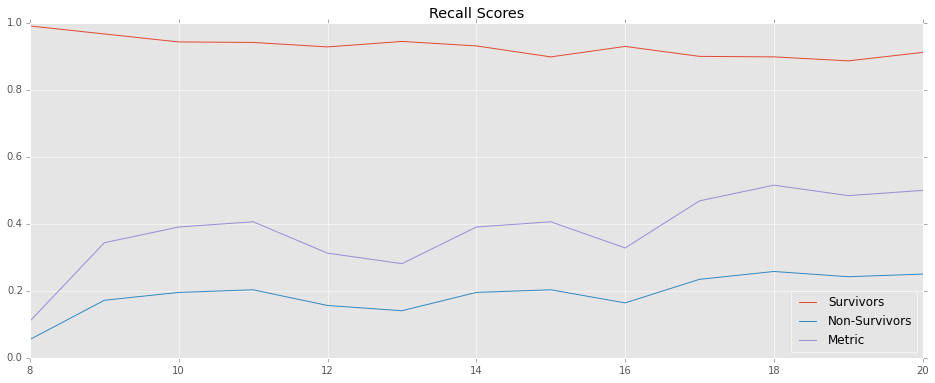

Optimized Parameters for recall are
{'activation': 'relu', 'features': 18, 'solver': 'lbfgs'}
optimized Scores are
             precision    recall  f1-score   support

          0       0.86      0.90      0.88       672
          1       0.33      0.26      0.29       128

avg / total       0.78      0.80      0.79       800



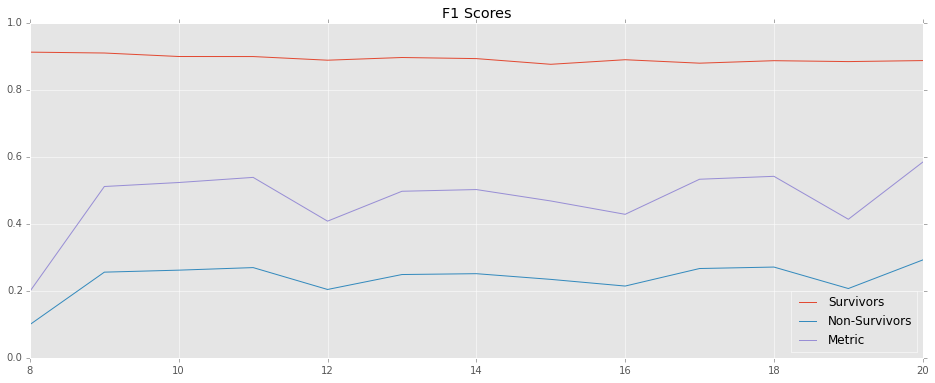

Optimized Parameters for f1 are
{'activation': 'relu', 'features': 20, 'solver': 'lbfgs'}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.86      0.91      0.89       672
          1       0.35      0.25      0.29       128

avg / total       0.78      0.81      0.79       800

Evaluating Kneighbors
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
ANALYSIS COMPLETE


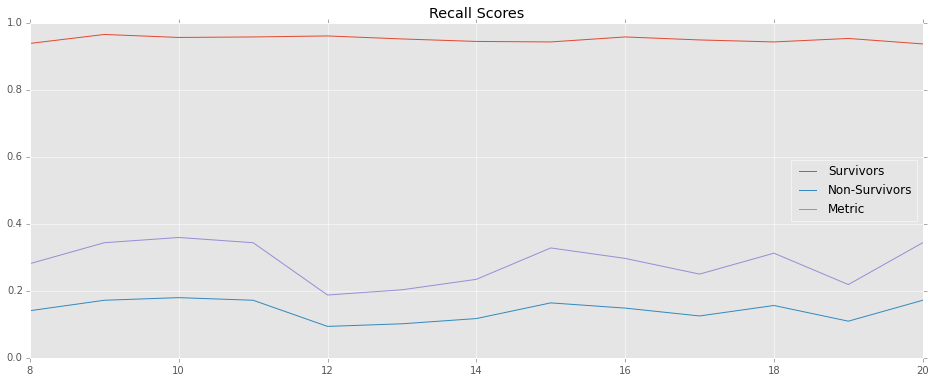

Optimized Parameters for recall are
{'n_neighbors': 8, 'weights': 'distance', 'features': 10, 'algorithm': 'auto'}
optimized Scores are
             precision    recall  f1-score   support

          0       0.86      0.96      0.91       672
          1       0.44      0.18      0.26       128

avg / total       0.79      0.83      0.80       800



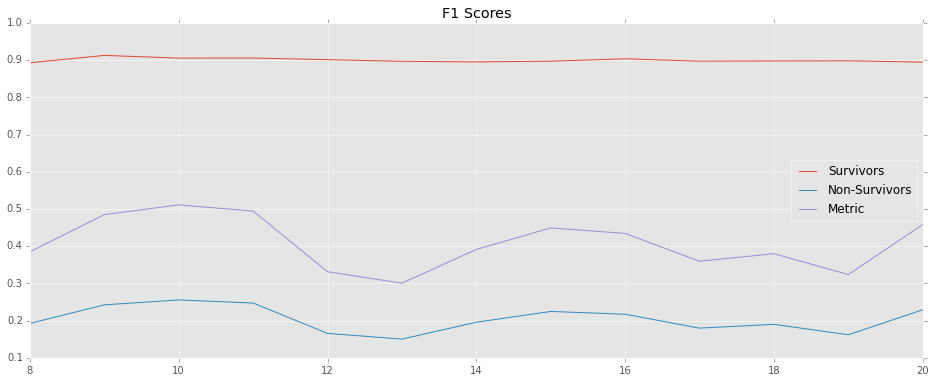

Optimized Parameters for f1 are
{'n_neighbors': 8, 'weights': 'distance', 'features': 10, 'algorithm': 'auto'}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.86      0.96      0.91       672
          1       0.44      0.18      0.26       128

avg / total       0.79      0.83      0.80       800

Evaluating LSVC
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
ANALYSIS COMPLETE


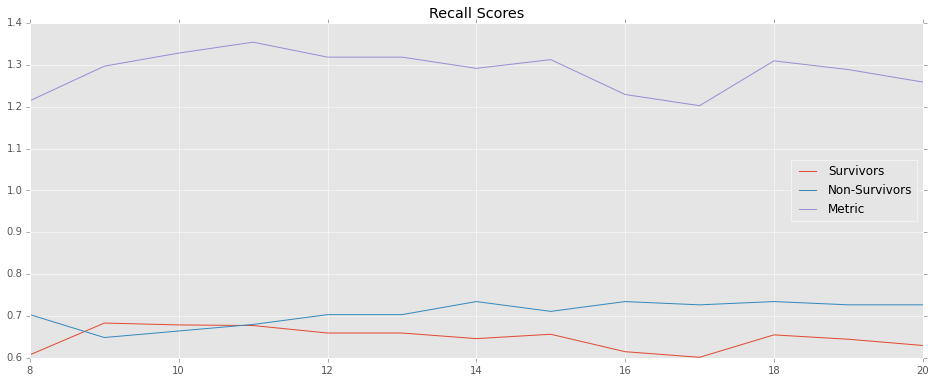

Optimized Parameters for recall are
{'loss': 'squared_hinge', 'C': 0.1, 'features': 11, 'class_weight': {0: 1, 1: 6}}
optimized Scores are
             precision    recall  f1-score   support

          0       0.92      0.68      0.78       672
          1       0.29      0.68      0.40       128

avg / total       0.82      0.68      0.72       800



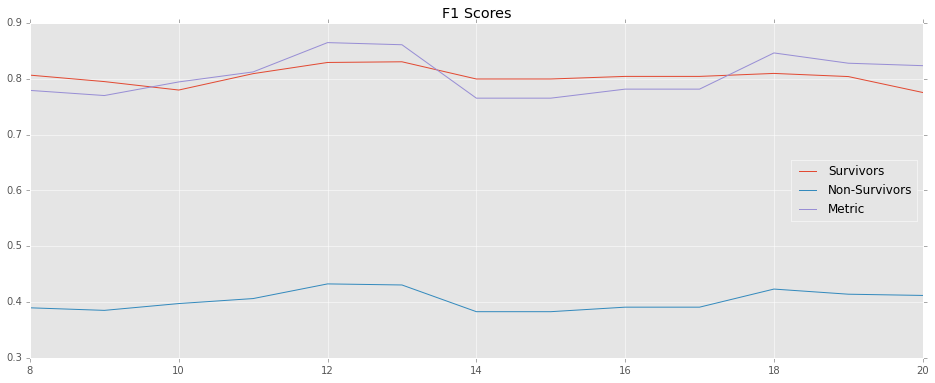

Optimized Parameters for f1 are
{'loss': 'squared_hinge', 'C': 0.4, 'features': 12, 'class_weight': {0: 1, 1: 4.5}}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.91      0.76      0.83       672
          1       0.33      0.62      0.43       128

avg / total       0.82      0.74      0.77       800



In [120]:
# OPTIMIZING THE KNEIGHBORS, LINEAR SUPPORT VECTOR AND MULTI LAYER PERCEPTRON CLASSIFIERS TO F1-SCORE AND RECALL
# OVER THE GIVEN PARAMETER SPACE AND OVER THE NUMBER OF FEATURES USING THE TOP 20 FEATURES RANKED 
# ACCORDING TO CHI2 SCORE
# RECALL FOR MORTALITY PREDICTION IS IMPORTANT IN THAT WE DON'T WANT FALSE NEGATIVES. 

# NEAREST NEIGHBOR CLASSIFIER PARAMETERS

kneighbors_params = {'n_neighbors': [2,4,6,8], 
                     'weights': ['uniform', 'distance'], 
                     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    }
#LinearSVC CLASSIFIER PARAMETERES
LSVC_params = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9,1],  
               'class_weight': [#{1:1, 0:1}, {1:2, 0:1}, {1:2.5, 0:1}, 
                                {1:3, 0:1}, {1:3.5, 0:1}, {1:4, 0:1}, 
                                {1:4.5, 0:1}, {1:5, 0:1}, {1:5.5, 0:1}, {1:6, 0:1}], 
                                #{1:6, 0:1}, {1:6.7, 0:1}, {1:7, 0:1}],
                   'loss':['hinge', 'squared_hinge']
              }


MLP_params = {
              'activation': ['identity', 'logistic', 'tanh', 'relu'], 
              'solver': ['lbfgs', 'sgd', 'adam']
             
             }




# DICTIONARY OF CLASSIFIERS AND CORRESPONDING PARAMETERS 


# CLASSIFIER SCORES
scores = ['f1', 'recall'] #'accuracy',, 'recall' , 'precision']

# DICTIONARY OF CLASSIFIERS AND CORRESPONDING PARAMETERS 
Kneighb = KNeighborsClassifier()
LSVC = svm.LinearSVC(random_state = 42)
MLP = MLPClassifier(random_state = 42)
#SVC = svm.SVC(random_state = 42)
KNeighbors_stuff = [Kneighb, kneighbors_params]
LSVC_stuff = [LSVC, LSVC_params]
MLP_stuff = [MLP, MLP_params]
classifiers = {
               
              }
#SVC_stuff = [SVC, SVC_params]
classifiers = {'LSVC': LSVC_stuff,
               'Kneighbors': KNeighbors_stuff, 
               'MLP': MLP_stuff
               
              }
                


for key in classifiers.keys():
    
    recall_mortality = 0
    f1_mortality = 0
    optimized_params = {}
    optimized = {}
    
    optimized_scores = ""
    recall_scores = {}
    f1_scores = {}

    print "Evaluating {}".format(key)
    for num_feats in range(8, (all_data.shape[1])):
        print "{} features".format(num_feats)
        # FEATURES AND TARGETS
        X_best = all_data[all_data.columns[1:num_feats]]
        y = all_data['hospital_expire_flag']

        X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.30, random_state = 42)
        
        if key == 'MLP':
            input_layer = num_feats
            middle_layer = int(math.ceil(num_feats/2))
            classifiers[key][0] = MLPClassifier(random_state = 42, 
                                                hidden_layer_sizes = (input_layer, middle_layer)
                                                )
            print "MLP Layers ({}, {})".format(num_feats, math.ceil(num_feats/2))
        # MAY NOT BE NECESSARY THE WAY THE CODE IS CURRENTLY BROKEN OUT
        for score in scores:
            #print"# Optimizing parameters for {} classifier to {} score using {} features".format(key, score, num_feats)

         
            clf = GridSearchCV(classifiers[key][0], classifiers[key][1], cv = 5, 
                           scoring = score)

            clf.fit(X_train, y_train)
    
            y_true, y_pred = y_test, clf.predict(X_test)
            scores_report = metrics.classification_report(y_true, y_pred)
            #print(scores_report)
         
            if score == 'recall':
                surv, mort = metrics.recall_score(y_true, y_pred, average = None)
                # a metric that maximizes both variables and minimizes the difference between them
                recall_metric = mort + surv - (abs(mort-surv))
                recall_scores[str(num_feats)] = [surv, mort, recall_metric]
                if (recall_metric > recall_mortality):
                    recall_mortality = recall_metric #math.sqrt(mort**2 + surv**2)
                    optimized = clf.best_params_
                    optimized['features'] = num_feats
                    optimized_scores = scores_report
                    recall_str = key + '_recall'
                    if recall_str not in optimized_clfs:
                        optimized_clfs[recall_str] = {}
                    optimized_clfs[recall_str]['CLF'] = clf
                    optimized_clfs[recall_str]['PARAMS'] = optimized
                    optimized_clfs[recall_str]['SCORES'] = optimized_scores
                    
         
            elif score == 'f1':
            
                surv_f1, mort_f1 = metrics.f1_score(y_true, y_pred, average = None)
                #a metric that maximizes both variables and minimizes the difference between them
                f1_metric = surv_f1 + mort_f1 - (abs(surv_f1-mort_f1))
                f1_scores[str(num_feats)] = [surv_f1, mort_f1, f1_metric]
                if (f1_metric > f1_mortality):
                    f1_mortality = f1_metric #math.sqrt(mort**2 + surv**2)
                    #recall_delta = abs(mort-surv)
                    f1_optimized = clf.best_params_
                    f1_optimized['features'] = num_feats
                    f1_optimized_scores = scores_report
                    f1_str = key + '_f1'
                    if f1_str not in optimized_clfs:
                        optimized_clfs[f1_str] = {}
                    optimized_clfs[f1_str]['CLF'] = clf
                    optimized_clfs[f1_str]['PARAMS'] = optimized
                    optimized_clfs[f1_str]['SCORES'] = optimized_scores
                    
                    
            
   
    print "ANALYSIS COMPLETE"
    recalls = pd.DataFrame.from_dict(recall_scores)
    recalls = recalls.transpose()
    recalls['features'] = recalls.index
    recalls['features'] = recalls['features'].apply(lambda x: int(x))
    recalls.sort_values(by = 'features', inplace = True)
    recalls.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
    recalls[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'Recall Scores', 
                                                           use_index = True, figsize = (16,6))
    plt.show()
    print "Optimized Parameters for recall are"
    print(optimized)
    print "optimized Scores are"
    print(optimized_scores)
        
    
    f1s = pd.DataFrame.from_dict(f1_scores)
    f1s = f1s.transpose()
    f1s['features'] = f1s.index
    f1s['features'] = f1s['features'].apply(lambda x: int(x))
    f1s.sort_values(by = 'features', inplace = True)
    f1s.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
    f1s[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'F1 Scores', use_index = True, figsize = (16,6))
    plt.show()
    print "Optimized Parameters for f1 are"
    print(f1_optimized)
    print "Optimized Scores are"
    print(f1_optimized_scores)
    

## CLASSIFIERS WITH OPTIMIZED PARAMETERS OVER VARIOUS TEST SIZES

In [122]:
print(optimized_clfs[optimized_clfs.keys()[0]]['SCORES'])

             precision    recall  f1-score   support

          0       0.86      0.97      0.91       672
          1       0.49      0.17      0.25       128

avg / total       0.80      0.84      0.80       800



In [88]:
'recall' in optimized_clfs.keys()[0]

True

In [85]:
optimized_clfs[optimized_clfs.keys()[0]]['CLF'].best_estimator_

SVC(C=0.7, cache_size=200, class_weight={0: 1, 1: 5}, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [110]:
optimized_clfs.keys()

['Kneighbors_f1',
 'LSVC_recall',
 'MLP_f1',
 'SVC_recall',
 'Kneighbors_recall',
 'MLP_recall',
 'SVC_f1',
 'LSVC_f1']

Evaluating Kneighbors_f1


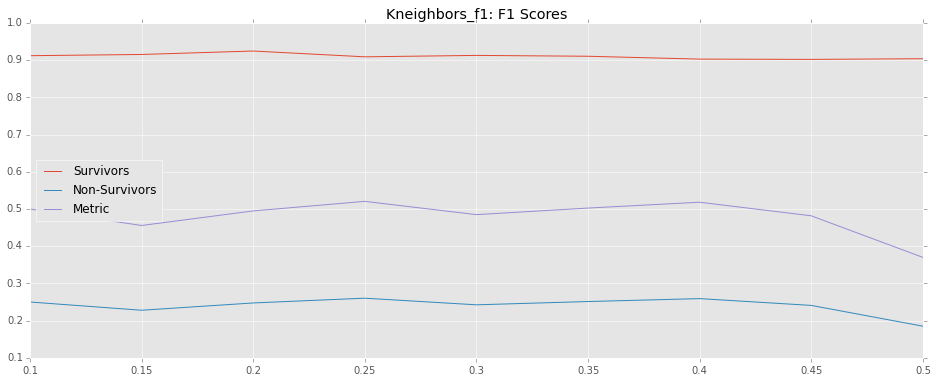

Optimized Parameters for Kneighbors_f1 f1-score are
{'n_neighbors': 8, 'weights': 'distance', 'features': 10, 'algorithm': 'auto', 'test_size': 0.25}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       564
          1       0.44      0.18      0.26       103

avg / total       0.80      0.84      0.81       667

Evaluating LSVC_recall
ANALYSIS COMPLETE


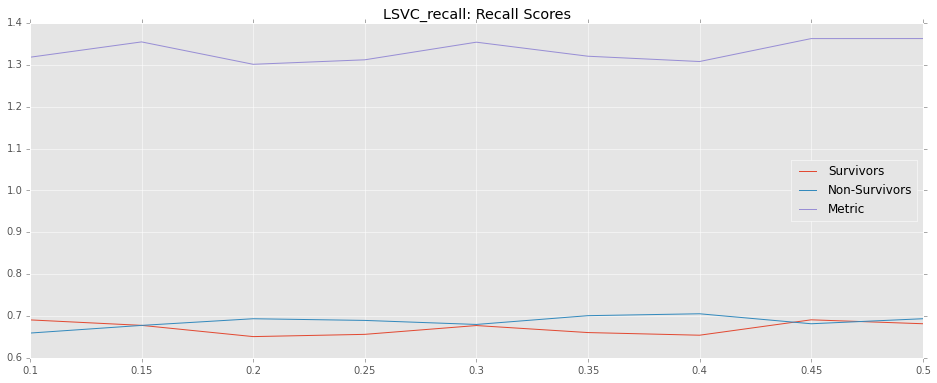

Optimized Parameters for LSVC_recall recall-score are
{'loss': 'squared_hinge', 'C': 0.1, 'test_size': 0.5, 'features': 11, 'class_weight': {0: 1, 1: 6}}
optimized Scores are
             precision    recall  f1-score   support

          0       0.92      0.68      0.78      1108
          1       0.31      0.69      0.43       225

avg / total       0.81      0.68      0.72      1333

Evaluating MLP_f1


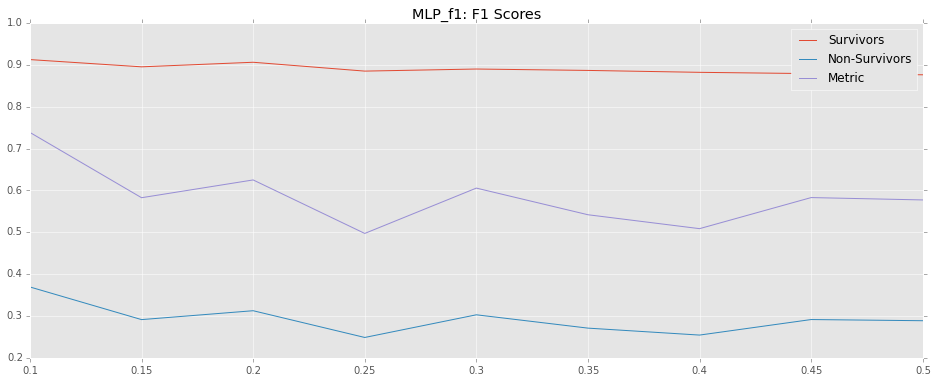

Optimized Parameters for MLP_f1 f1-score are
{'test_size': 0.10000000000000001, 'activation': 'relu', 'features': 20, 'solver': 'lbfgs'}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       223
          1       0.57      0.27      0.37        44

avg / total       0.82      0.85      0.82       267

Evaluating SVC_recall
ANALYSIS COMPLETE


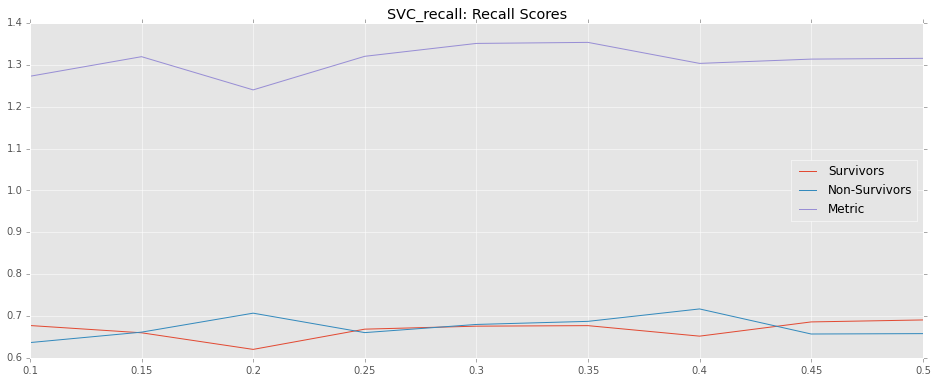

Optimized Parameters for SVC_recall recall-score are
{'kernel': 'rbf', 'C': 0.7, 'features': 13, 'degree': 2, 'decision_function_shape': 'ovr', 'test_size': 0.34999999999999998, 'class_weight': {0: 1, 1: 5}}
optimized Scores are
             precision    recall  f1-score   support

          0       0.92      0.68      0.78       786
          1       0.28      0.69      0.40       147

avg / total       0.82      0.68      0.72       933

Evaluating Kneighbors_recall
ANALYSIS COMPLETE


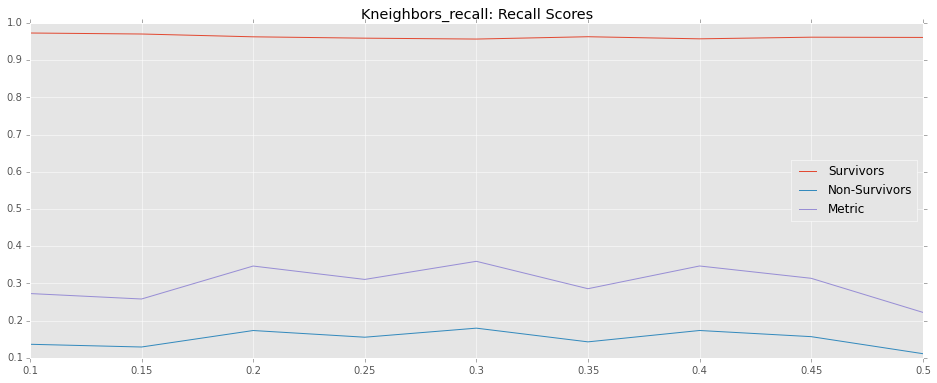

Optimized Parameters for Kneighbors_recall recall-score are
{'n_neighbors': 8, 'weights': 'distance', 'features': 10, 'algorithm': 'auto', 'test_size': 0.30000000000000004}
optimized Scores are
             precision    recall  f1-score   support

          0       0.86      0.96      0.91       672
          1       0.44      0.18      0.26       128

avg / total       0.79      0.83      0.80       800

Evaluating MLP_recall
ANALYSIS COMPLETE


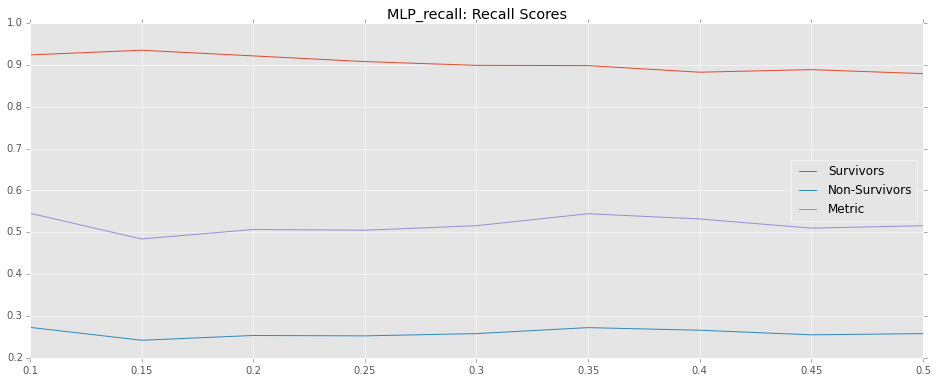

Optimized Parameters for MLP_recall recall-score are
{'test_size': 0.10000000000000001, 'activation': 'relu', 'features': 18, 'solver': 'lbfgs'}
optimized Scores are
             precision    recall  f1-score   support

          0       0.87      0.92      0.89       223
          1       0.41      0.27      0.33        44

avg / total       0.79      0.82      0.80       267

Evaluating SVC_f1


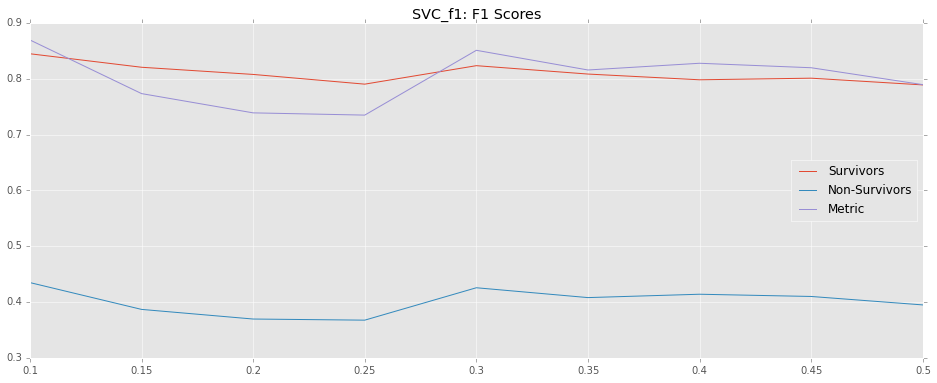

Optimized Parameters for SVC_f1 f1-score are
{'kernel': 'sigmoid', 'C': 0.8, 'features': 12, 'degree': 2, 'decision_function_shape': 'ovr', 'test_size': 0.10000000000000001, 'class_weight': {0: 1, 1: 5}}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.90      0.79      0.84       223
          1       0.35      0.57      0.43        44

avg / total       0.81      0.76      0.78       267

Evaluating LSVC_f1


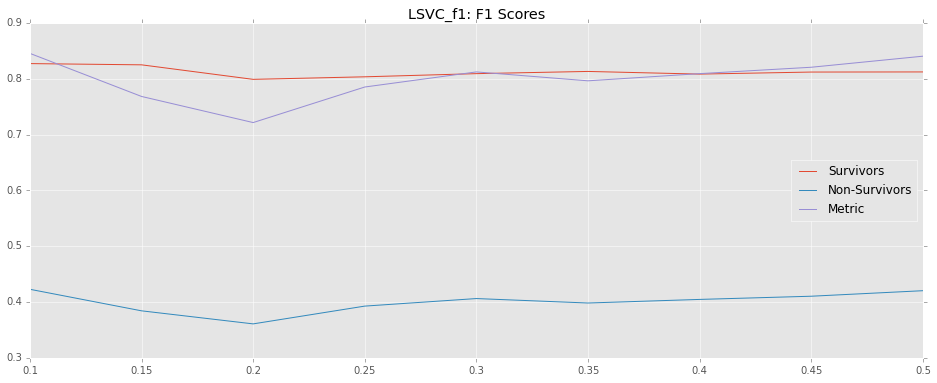

Optimized Parameters for LSVC_f1 f1-score are
{'loss': 'squared_hinge', 'C': 0.4, 'test_size': 0.10000000000000001, 'features': 12, 'class_weight': {0: 1, 1: 4.5}}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.90      0.76      0.83       223
          1       0.33      0.59      0.42        44

avg / total       0.81      0.73      0.76       267

OPTIMIZATION COMPLETE


In [124]:


for key in optimized_clfs.keys():
    
    recall_mortality = 0
    f1_mortality = 0
    optimized_params = {}
    optimized = {}
    optimized_scores = ""
    recall_scores = {}
    f1_scores = {}

    print "Evaluating {}".format(key)
    for testes_size in np.linspace(0.1, 0.5, 9):
        # DEFINING MLP HERE SO THAT WE CAN ALTER THE NUMBER OF INPUT HIDDEN NODES TO MATCH FEATURES
        
        #print "{} test size".format(testes_size)
        # FEATURES AND TARGETS
        features = optimized_clfs[key]['PARAMS']['features']
        clf = optimized_clfs[key]['CLF'].best_estimator_
        X_best = all_data[all_data.columns[1:features]]
        y = all_data['hospital_expire_flag']

        X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = testes_size, random_state = 42)
        
        
        
        clf.fit(X_train, y_train)
    
        y_true, y_pred = y_test, clf.predict(X_test)
        scores_report = metrics.classification_report(y_true, y_pred)
            #print(scores_report)
         
        if 'recall' in key:
            surv, mort = metrics.recall_score(y_true, y_pred, average = None)
                # a metric that maximizes both variables and minimizes the difference between them
            recall_metric = mort + surv - (abs(mort-surv))
            recall_scores[str(testes_size)] = [surv, mort, recall_metric]
            if (recall_metric > recall_mortality):
                recall_mortality = recall_metric #math.sqrt(mort**2 + surv**2)
                optimized = optimized_clfs[key]['CLF'].best_params_
                optimized['test_size'] = testes_size
                optimized_clfs[key]['PARAMS']['test_size'] = testes_size
                optimized_clfs[key]['SCORES'] = scores_report
                optimized_scores = scores_report
                
         
        elif 'f1' in key:
                
            surv_f1, mort_f1 = metrics.f1_score(y_true, y_pred, average = None)
                #a metric that maximizes both variables and minimizes the difference between them
            f1_metric = surv_f1 + mort_f1 - (abs(surv_f1-mort_f1))
            f1_scores[str(testes_size)] = [surv_f1, mort_f1, f1_metric]
            if (f1_metric > f1_mortality):
                f1_mortality = f1_metric #math.sqrt(mort**2 + surv**2)
                #recall_delta = abs(mort-surv)
                f1_optimized = optimized_clfs[key]['CLF'].best_params_
                f1_optimized['test_size'] = testes_size
                optimized_clfs[key]['PARAMS']['test_size'] = testes_size
                optimized_clfs[key]['SCORES'] = scores_report
                f1_optimized_scores = scores_report
                
            
    if 'recall' in key:   
        print "ANALYSIS COMPLETE"
        recalls = pd.DataFrame.from_dict(recall_scores)
        recalls = recalls.transpose()
        recalls['test_size'] = recalls.index
        recalls['test_size'] = recalls['test_size'].apply(lambda x: float(x))
        recalls.sort_values(by = 'test_size', inplace = True)
        recalls.columns = ['Survivors', 'Non-Survivors', 'Metric', 'test_size']
        recalls[['Survivors', 'Non-Survivors', 'Metric']].plot(title = key + ': Recall Scores', 
                                                           use_index = True, figsize = (16,6))
        plt.show()
        print "Optimized Parameters for {} recall-score are".format(key)
        print(optimized)
        print "optimized Scores are"
        print(optimized_scores)
    
    
    elif 'f1' in key:
        f1s = pd.DataFrame.from_dict(f1_scores)
        f1s = f1s.transpose()
        f1s['test_size'] = f1s.index
        f1s['test_size'] = f1s['test_size'].apply(lambda x: float(x))
        f1s.sort_values(by = 'test_size', inplace = True)
        f1s.columns = ['Survivors', 'Non-Survivors', 'Metric', 'test_Size']
        f1s[['Survivors', 'Non-Survivors', 'Metric']].plot(title = key + ': F1 Scores', use_index = True, figsize = (16,6))
        plt.show()
        print "Optimized Parameters for {} f1-score are".format(key)
        print(f1_optimized)
        print "Optimized Scores are"
        print(f1_optimized_scores)
    
print "OPTIMIZATION COMPLETE"

In [191]:
first = True
for key in optimized_clfs.keys():
    print(key)
    print(optimized_clfs[key]['SCORES'])

    # CONVERT SCORES_REPORT TO DATAFRAME
    scores = optimized_clfs[key]['SCORES'].split()
    #display(scores)
    cols = scores[:4]
    ind = [x for x in scores if scores.index(x) in [4,9,14, 15, 16]]
    ind[2] = ind[2] + ind[3] + ind[4] 
    ind.pop()
    ind.pop()
    dat = [scores[5:9], scores[10:14], scores[17:22]]
    #display(cols)
    #display(ind)
    #display(dat)
    arrays = [[key, key, key], ind]
    tuples = list(zip(*arrays))
    mindex = pd.MultiIndex.from_tuples(tuples, names=['Classifier', 'Classes'])
    if first:
        scores_frame = pd.DataFrame(dat, columns = cols, index = mindex)
        first = False
    else: 
        scores_frame = scores_frame.append(pd.DataFrame(dat, columns = cols, index = mindex))

scores_frame

Kneighbors_f1
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       564
          1       0.44      0.18      0.26       103

avg / total       0.80      0.84      0.81       667

LSVC_recall
             precision    recall  f1-score   support

          0       0.92      0.68      0.78      1108
          1       0.31      0.69      0.43       225

avg / total       0.81      0.68      0.72      1333

MLP_f1
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       223
          1       0.57      0.27      0.37        44

avg / total       0.82      0.85      0.82       267

SVC_recall
             precision    recall  f1-score   support

          0       0.92      0.68      0.78       786
          1       0.28      0.69      0.40       147

avg / total       0.82      0.68      0.72       933

Kneighbors_recall
             precision    recall  f1-score   support

          0       0.86  

precision recall f1-score support
Classifier        Classes                                    
Kneighbors_f1     0              0.87   0.96     0.91     564
                  1              0.44   0.18     0.26     103
                  avg/total      0.80   0.84     0.81     667
LSVC_recall       0              0.92   0.68     0.78    1108
                  1              0.31   0.69     0.43     225
                  avg/total      0.81   0.68     0.72    1333
MLP_f1            0              0.87   0.96     0.91     223
                  1              0.57   0.27     0.37      44
                  avg/total      0.82   0.85     0.82     267
SVC_recall        0              0.92   0.68     0.78     786
                  1              0.28   0.69     0.40     147
                  avg/total      0.82   0.68     0.72     933
Kneighbors_recall 0              0.86   0.96     0.91     672
                  1              0.44   0.18     0.26     128
                  avg/total      0.79   0.83     0.80     800
MLP_recall        0              0.87   0.92     0.89     223
                  1              0.41   0.27     0.33      44
                  avg/total      0.79   0.82     0.80     267
SVC_f1            0              0.90   0.79     0.84     223
                  1              0.35   0.57     0.43      44
                  avg/total      0.81   0.76     0.78     267
LSVC_f1           0              0.90   0.76     0.83     223
                  1              0.33   0.59     0.42      44
                  avg/total      0.81   0.73     0.76     267

In [217]:
display(scores_frame.iloc[scores_frame.index.get_level_values('Classes') == 'avg/total'])
display(scores_frame.iloc[scores_frame.index.get_level_values('Classes') == '0'])
display(scores_frame.iloc[scores_frame.index.get_level_values('Classes') == '1'])

,,precision,recall,f1-score,support
Classifier,Classes,,,,
Kneighbors_f1,avg/total,0.80,0.84,0.81,667
LSVC_recall,avg/total,0.81,0.68,0.72,1333
MLP_f1,avg/total,0.82,0.85,0.82,267
SVC_recall,avg/total,0.82,0.68,0.72,933
Kneighbors_recall,avg/total,0.79,0.83,0.80,800
MLP_recall,avg/total,0.79,0.82,0.80,267
SVC_f1,avg/total,0.81,0.76,0.78,267
LSVC_f1,avg/total,0.81,0.73,0.76,267


,,precision,recall,f1-score,support
Classifier,Classes,,,,
Kneighbors_f1,0,0.87,0.96,0.91,564
LSVC_recall,0,0.92,0.68,0.78,1108
MLP_f1,0,0.87,0.96,0.91,223
SVC_recall,0,0.92,0.68,0.78,786
Kneighbors_recall,0,0.86,0.96,0.91,672
MLP_recall,0,0.87,0.92,0.89,223
SVC_f1,0,0.90,0.79,0.84,223
LSVC_f1,0,0.90,0.76,0.83,223


,,precision,recall,f1-score,support
Classifier,Classes,,,,
Kneighbors_f1,1,0.44,0.18,0.26,103
LSVC_recall,1,0.31,0.69,0.43,225
MLP_f1,1,0.57,0.27,0.37,44
SVC_recall,1,0.28,0.69,0.40,147
Kneighbors_recall,1,0.44,0.18,0.26,128
MLP_recall,1,0.41,0.27,0.33,44
SVC_f1,1,0.35,0.57,0.43,44
LSVC_f1,1,0.33,0.59,0.42,44


In [186]:
arrays = [[key, key, key], ind]
tuples = list(zip(*arrays))
mindex = pd.MultiIndex.from_tuples(tuples, names=['Classifier', 'Classes'])
pd.DataFrame(dat, columns = cols, index = mindex)

precision recall f1-score support
Classifier Classes                                    
LSVC_f1    0              0.90   0.76     0.83     223
           1              0.33   0.59     0.42      44
           avg/total      0.81   0.73     0.76     267

In [174]:
pd.DataFrame(index = ind, columns = cols, data = dat)

,precision,recall,f1-score,support
0,0.90,0.76,0.83,223
1,0.33,0.59,0.42,44
avg/total,0.81,0.73,0.76,267


In [149]:
[x for x in scores if scores.index(x) in [4,9,14, 15, 16]]

['0', '1', 'avg', '/', 'total']

In [179]:
for key in optimized_clfs.keys():
    print(key)
    print(optimized_clfs[key]['SCORES'])

Kneighbors_f1
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       564
          1       0.44      0.18      0.26       103

avg / total       0.80      0.84      0.81       667

LSVC_recall
             precision    recall  f1-score   support

          0       0.92      0.68      0.78      1108
          1       0.31      0.69      0.43       225

avg / total       0.81      0.68      0.72      1333

MLP_f1
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       223
          1       0.57      0.27      0.37        44

avg / total       0.82      0.85      0.82       267

SVC_recall
             precision    recall  f1-score   support

          0       0.92      0.68      0.78       786
          1       0.28      0.69      0.40       147

avg / total       0.82      0.68      0.72       933

Kneighbors_recall
             precision    recall  f1-score   support

          0       0.86  

In [ ]:
recalls = pd.DataFrame.from_dict(recall_scores)
f1s = pd.DataFrame.from_dict(f1_scores)
recalls = recalls.transpose()
f1s = f1s.transpose()
recalls['features'] = recalls.index
f1s['features'] = f1s.index
recalls['features'] = recalls['features'].apply(lambda x: int(x))
f1s['features'] = f1s['features'].apply(lambda x: int(x))

recalls.sort_values(by = 'features', inplace = True)
f1s.sort_values(by = 'features', inplace = True)
#recalls[recalls[['0', '1']].plot(use_index = True)
recalls.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
f1s.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
display(recalls)
display(f1s)

In [ ]:
recalls[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'Recall Scores', use_index = True, figsize = (16,6))
f1s[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'F1 Scores', use_index = True, figsize = (16,6))

In [ ]:
display(metrics.recall_score(y_true, y_pred, average = None, labels = [0,1]))
print(metrics.classification_report(y_true, y_pred))

In [ ]:
  

clf_KNC.fit(X_train, y_train)
scores = cross_val_score(clf_KNC, X_best, y, cv=5)
print "Scores from KNeighbors Classificaiton"
display(scores)  
clf_KNC.score(X_test, y_test)
y_predsKNC = clf_KNC.predict(X_test)
print "Confusion matrix for KNeighbors Classification"
display(metrics.confusion_matrix(y_test, y_predsKNC))
print "\n\n"
    
    
    
# SUPPORT VECTOR CLASSIFIER     
clf_SVC = svm.SVC(C=1.0, class_weight={1:3, 0:1}, max_iter=-1, 
        tol=0.001, verbose=False, random_state = 42).fit(X_train, y_train)
clf_SVC.fit(X_train, y_train)
scores = cross_val_score(clf_SVC, X_best, y, cv=5)
print "Scores from Linear Support Vector Classificaiton"
display(scores)  
clf_SVC.score(X_test, y_test)
y_predsSVC = clf_SVC.predict(X_test)
print "Confusion matrix for Support Vector Classification"
display(metrics.confusion_matrix(y_test, y_predsSVC))
print "\n\n"

    
# LINEAR SUPPORT VECTOR CLASSIFIER
clf_LSVC = svm.LinearSVC(C=1.0, class_weight={1:3, 0:1}, random_state = 42).fit(X_train, y_train)
clf_LSVC.fit(X_train, y_train)
scores = cross_val_score(clf_LSVC, X_best, y, cv=5)
print "Scores from Linear Support Vector Classificaiton"
display(scores)  
clf_LSVC.score(X_test, y_test)
y_predsLSVC = clf_LSVC.predict(X_test)
print "Confusion matrix for Linear Support Vector Classification"
display(metrics.confusion_matrix(y_test, y_predsLSVC))
print "\n\n"
 

# DECISION TREE CLASSIFIER
clf_Tree = DecisionTreeClassifier(random_state = 42, class_weight = {1:3, 0:1})
scores = cross_val_score(clf_Tree, X_best, y, cv=5)
print "Scores from Decision Tree Classifier"
display(scores)  
clf_Tree.fit(X_train, y_train)
clf_Tree.score(X_test, y_test)
y_predsTree = clf_Tree.predict(X_test)
print "Confusion matrix for Decision Tree"
display(metrics.confusion_matrix(y_test, y_predsTree))


'''
# GAUSSIAN NAIVE BAYES CLASSIFIER

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
### return the fit classifier
print "Gaussian Naive Bayes Classifier Score"
nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
print "Confusion Matrix for Gaussian Naive Bayes Classifier"
metrics.confusion_matrix(y_test, y_predsGNB)



'''

print "\n\n Complete"

## XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
## XXXXXXX    LEGACY CODE STARTS HERE    XXXXXX
## XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
# CONVERT DATE/TIME STRINGS IN DATA TO DATE_TIME OBJECTS SO 
# THAT CALCULATIONS CAN BE PERFORMED TO DETERMINE STAY LENGTH AND PATIENT AGE

donkey = [x for x in chart_data.columns if 'time' in x]
for donk in donkey:
    chart_data[donk] = pd.to_datetime(chart_data[donk])

for index, row in chart_data.iterrows():
    staylen = relativedelta(row['outtime'], row['intime']).hours
    chart_data.set_value(index, 'stay_duration', staylen)


# SETTING ICUSTAY_ID AS INDEX TO FACILITATE MERGING DATA_FRAMES BY 
# ICUSTAY_ID
chart_data2 = chart_data.set_index(['icustay_id'], inplace = False)
lab_data2 = lab_data.set_index(['icustay_id'], inplace = False)


# MERGING CHART AND LAB DATAFRAMES. DROPPING DUPLICATE COLUMNS FROM LAB DATA PRIOR TO MERGE
lab_data2.drop(['hospital_expire_flag', 'subject_id', 'gender', 'intime', 'outtime'], 
               axis = 1, inplace = True)

all_data = chart_data2.merge(lab_data2, left_index = True, right_index = True, how='left', sort = True, 
                            suffixes = ('chart', 'lab'))

# MOVING ICUSTAY_ID BACK TO IT'S OWN COLUMN AND RE-INDEXING THE 
# DATA_FRAME. RESHUFFLING COLUMNS SO THAT ICUSTAY_ID AND SUBJECT_ID ARE LEFT MOST

all_data['icustay_id'] = all_data.index
all_data.set_index(np.arange(all_data.shape[0]), inplace = True)

cols = list(all_data.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
all_data = all_data[cols]

print "complete"

In [ ]:
for col in all_data.columns:
    print col
    

In [ ]:
## Isolate continuous (float64) and categorical variables for feature selection process. 
# Feature selection tools require features to be of the same type. Data will be separated, 
# feature correlations will be calculated. 

# variable 'monkey' because i try to have a little fun. 

monkey = list(all_data.columns[all_data.dtypes == 'float64'])
monkey.insert(0,'icustay_id')
monkey.insert(1,'hospital_expire_flag')
#monkey.pop(monkey.index('Height'))
#monkey.pop(monkey.index('Weight'))
# all continuous variables
cont_data = all_data[monkey]

monkey = list(all_data.columns[all_data.dtypes == 'object'])
monkey.insert(0,'icustay_id')
monkey.insert(1,'hospital_expire_flag')
#all categorical variables
cat_data = all_data[monkey]

# Shift all continuous values positive
for col in cont_data.columns[2:]:
    col_min = cont_data.loc[:,col].min()
    if col_min < 0:
        cont_data.loc[:,col] = cont_data.loc[:,col].apply(lambda x: x-col_min)


## FILTERING OUT EXTREME OUTLIERS FROM CONTINUOUS/FLOAT64 DATA BLOCKS


suffix = '_outliers'


# ITERATE THROUGH DATAFRAMES IN cont_dict 
# DOING ONE LOOP FOR DEVELOPMENT
for feature in cont_data.columns[2:]:
    to_nan = []
    
    names_dict = {}
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(cont_data.loc[:,feature].dropna(), 25)
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(cont_data.loc[:,feature].dropna(), 75)
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    # BECAUSE DATA IS NOT NORMAL EXPLORING DIFFERENT RANGE FACTORS
    step = 5*(Q3 - Q1)

    # Display the outliers
    # print "Data points considered outliers for the feature '{}':".format(feature)
    # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
    to_nan = list(cont_data[~((cont_data.loc[:,feature] >= Q1 - step) & 
                                                      (cont_data.loc[:,feature] <= Q3 + step))].index)
   
    # OPTIONAL: Select the indices for data points you wish to remove
   
    cont_data.iloc[to_nan, cont_data.columns.get_loc(feature)] = np.nan
    
cont_data.head()
print "complete"

In [ ]:
cont_data.hospital_expire_flag.sum()

## INITIALLY THOUGHT IT WAS DESIREABLE TO DO NORMALIZATION AND SCALING HERE BUT TRANSFORMS REQUIRE NO NULL VALUES SO THIS WILL BE PERFORMED AFTER

In [ ]:
col = 'Lactate_max_df'
plt.subplots(figsize=(10,4))
cont_data[col].dropna().plot.kde()
xmin = np.percentile(cont_data[col].dropna(), .1)
xmax = np.percentile(cont_data[col].dropna(), 99.9)
plt.plot([], label=' ',color='lightgray')
plt.plot([], label='Max Value ={}'.format(cont_data[col].dropna().max()),
             color='lightgray')
plt.plot([], label='Min Value ={}'.format(cont_data[col].dropna().min()),
             color='lightgray')

#plt.xlim(xmin, xmax)
print "complete"

In [ ]:
# This filtering on feature selection could be done far earlier in the process. 
# Could do it in smaller blocks where the variables are aligned with the subject ID
# Variables are not present for all subject_id's or ICU stays. 
# In order to select features, we need to drop_na. So we need to find blocks of features 
# that are present for the same ICU stays etc. In retrospect this could be done earlier in 
# the process before all the data is merged. 

## CREATING CONTINUOUS / FLOAT64 DATA BLOCKS FOR FEATURE SELECTION


cols = ['icustay_id', 'hospital_expire_flag', 'Height', 'Weight',
       'stay_duration']
cont_data_HWStay = cont_data[cols].dropna()
cont_data_HWStay.reset_index(drop = True, inplace = True)
print "Height, Weight and Stay  = {}".format(cont_data_HWStay.shape[0])

cols = ['icustay_id', 'hospital_expire_flag', 'GCS_total']
cont_data_GCST = cont_data[cols].dropna()
cont_data_GCST.reset_index(drop = True, inplace = True)
print "GCS_total  = {}".format(cont_data_GCST.shape[0])

cols = [x for x in cont_data.columns if 'Lactate_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_Lac = cont_data[cols].dropna()
cont_data_Lac.reset_index(drop = True, inplace = True)
print "Lactate  = {}".format(cont_data_Lac.shape[0])

cols = [x for x in cont_data.columns if 'O2sat_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_O2sat = cont_data[cols].dropna()
cont_data_O2sat.reset_index(drop = True, inplace = True)
print "O2sat  = {}".format(cont_data_O2sat.shape[0])

cols = [x for x in cont_data.columns if (('pH_' in x) | ('_df' in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_labpH = cont_data[cols].dropna()
cont_data_labpH.reset_index(drop = True, inplace = True)
print "labpH  = {}".format(cont_data_labpH.shape[0])


cols = [x for x in cont_data.columns if 'BP_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_BP = cont_data[cols].dropna()
cont_data_BP.reset_index(drop = True, inplace = True)
print "BP  = {}".format(cont_data_BP.shape[0])

cols = [x for x in cont_data.columns if 'HR_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_HR = cont_data[cols].dropna()
cont_data_HR.reset_index(drop = True, inplace = True)
print "HR  = {}".format(cont_data_HR.shape[0])


cols = [x for x in cont_data.columns if 'O2_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_O2 = cont_data[cols].dropna()
cont_data_O2.reset_index(drop = True, inplace = True)
print "O2  = {}".format(cont_data_O2.shape[0])

cols = [x for x in cont_data.columns if 'RR_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_RR = cont_data[cols].dropna()
cont_data_RR.reset_index(drop = True, inplace = True)
print "RR  = {}".format(cont_data_RR.shape[0])


cols = [x for x in cont_data.columns if 'TempC_Calc' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_TCalc = cont_data[cols].dropna()
cont_data_TCalc.reset_index(drop = True, inplace = True)
print "TCalc  = {}".format(cont_data_TCalc.shape[0])

cols = [x for x in cont_data.columns if (('TempC_' in x) & ('TempC_C' not in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_TC = cont_data[cols].dropna()
cont_data_TC.reset_index(drop = True, inplace = True)
print "TC  = {}".format(cont_data_TC.shape[0])

cols = [x for x in cont_data.columns if (('pH_' in x) | ('pH2_' in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_pH = cont_data[cols].dropna()
cont_data_pH.reset_index(drop = True, inplace = True)
print "pH  = {}".format(cont_data_pH.shape[0])

cont_dict = {'BP': cont_data_BP, 
             'HR': cont_data_HR, 
             'O2': cont_data_O2, 
             'RR': cont_data_RR, 
             'TCalc': cont_data_TCalc, 
             'TC': cont_data_TC,
             'pH': cont_data_pH,
             'GCST': cont_data_GCST, 
             'HWStay': cont_data_HWStay,
             'LAC' : cont_data_Lac, 
             'O2Sat': cont_data_O2sat, 
             'labpH' : cont_data_labpH
            }


print "complete"

### MAY WANT TO CHECK NORMALITY HERE BEFORE FILTERING OUTLIERS

In [ ]:
# BOXCOX TRANSFORMING ALL DATA TO NORMALIZE

for frame in cont_dict.keys():
    for feature in cont_dict[frame][cont_dict[frame].columns[2:]]:
        feature_index = cont_dict[frame].columns.get_loc(feature)
        print "{}    old skew      {}".format(feature, cont_dict[frame][feature].skew())
        
        cont_dict[frame].iloc[:,feature_index] = scats.boxcox(cont_dict[frame].iloc[:,feature_index].add(1))[0]
        print "{}    new_skew      {}{}".format(feature, cont_dict[frame][feature].skew(),'\n')

        

In [ ]:
# SCALING DATA USING ROBUST_SCALE TO ACCOUNT FOR OUTLIERS
for frame in cont_dict.keys():
    cont_dict[frame].iloc[:,2:] = preprocessing.robust_scale(cont_dict[frame].iloc[:,2:], 
                                                axis = 0, with_centering=True, with_scaling=True, 
                                                quantile_range=(25.0, 75.0), copy=True)

print "complete"

In [ ]:
## FILTERING OUT EXTREME OUTLIERS FROM CONTINUOUS/FLOAT64 DATA BLOCKS


suffix = '_outliers'


# ITERATE THROUGH DATAFRAMES IN cont_dict 
# DOING ONE LOOP FOR DEVELOPMENT
for frame in cont_dict.keys():
    for feature in cont_dict[frame].columns[2:]:
        feature_index = cont_dict[frame].columns.get_loc(feature)
        to_nan = []
    
        names_dict = {}
    
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(cont_data.loc[:,feature].dropna(), 25)
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(cont_data.loc[:,feature].dropna(), 75)
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        # BECAUSE DATA IS NOT NORMAL EXPLORING DIFFERENT RANGE FACTORS
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = cont_dict[frame][~((cont_dict[frame][feature] >= Q1 - step) & 
                                                        (cont_dict[frame][feature] <= Q3 + step))].index
        

        
    all_outliers = []
    for feature in names_dict.keys():
        all_outliers.extend(names_dict[feature])
    print "the total outlier indices = {}".format(len(all_outliers))
    indices, counts = np.unique(all_outliers, return_counts = True)
    outlier_dict = {'counts': counts,
                    'indices': indices
                   }
    outlier_df = pd.DataFrame(outlier_dict)

    outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
    print "the following data points have >=2 outlying feature and will be removed: \n{}".format(outliers)
    # Remove the outliers, if any were specified


    cont_dict[frame] = cont_dict[frame].drop(cont_dict[frame].index[outliers]).reset_index(drop = True)
    print "{}   {}".format(frame, cont_dict[frame].shape[0])

## DISPLAY CONTINUOUS/FLOAT64 DATA BLOCK SUMMARY STATS WITH OUTLIERS REMOVED

## PLOT DENSITY OF CONTINUOUS/FLOAT64 VARIABLES WITH OUTLIERS REMOVED

In [ ]:
key = cont_dict.keys()[2]
for col in cont_dict[key].columns[2:]:
    plt.subplots(figsize=(10,4))
    cont_dict[key][col].plot.kde()
    xmin = np.percentile(cont_dict[key][col], 1)
    xmax = np.percentile(cont_dict[key][col], 99)
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='Max Value ={}'.format(cont_dict[key][col].max()),
             color='lightgray')
    plt.plot([], label='Min Value ={}'.format(cont_dict[key][col].min()),
             color='lightgray')

    plt.xlim(xmin, xmax)
    plt.title(col)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)

#cont_dict['BP'].shape

## FEATURE SELECTION FOR CONTINUOUS/FLOAT64 DATA

In [ ]:
X_cont[col].shape == cont_dict[frame].shape
print "{}   {}".format(X_cont[col].shape, cont_dict[frame].shape)

In [ ]:
cont_feature_scores = pd.DataFrame()

for frame in cont_dict.keys():
    
    cont_dict[frame].dropna(inplace=True)
    X_cont = cont_dict[frame].drop(['hospital_expire_flag', 'icustay_id'], axis = 1)
    y_cont = cont_dict[frame]['hospital_expire_flag']
    below_zeros = list(X_cont.columns[X_cont.min() < 0])
    # SelectKBest can't deal with negative numbers so we shift any variables with negative values
    # up so that the most negative values = 0
    
    ##### THIS CODE DOES NOT SHIFT THE VALUES IN THE ORIGINAL DATAFRAME #####
    
    for col in below_zeros:
        feature_index = cont_dict[frame].columns.get_loc(col)
        col_min = X_cont[col].min()
        X_cont[col] = X_cont[col].apply(lambda x: x-col_min)
        cont_dict[frame].iloc[:,feature_index] = X_cont[col]
    
    selector = SelectKBest(k='all')
    selector.fit(X_cont, y_cont)
    d = {'pvalues': pd.Series(selector.pvalues_, index = X_cont.columns),
         'scores' : pd.Series(selector.scores_, index = X_cont.columns)
        }
    cont_feature_scores = cont_feature_scores.append(pd.DataFrame(d))

    
cont_feature_scores.sort_values(['pvalues'], axis = 0, ascending = True, inplace = True)

tops = cont_feature_scores.head(20).transpose().columns
bottoms = cont_feature_scores.tail(20).transpose().columns
display(tops[:5])
display(bottoms[:3])
display(cont_dict.keys())

In [ ]:
cont_feature_scores

In [ ]:
# PLOT 3 OF THE HIGHEST SCORED AND 3 OF THE LOWEST SCORED FEATURES TO VISUALLY VERIFY THERE ARE 
# DIFFERENCES BETWEEN SURVIVAL AND NON-SURVIVAL GROUPS

#cont_dict['RR'].plot.scatter(x='hospital_expire_flag', y='RR_med')
#for col in cont_dict['GCST'][''.columns[2:]:
cont_dict['GCST'][['hospital_expire_flag','GCS_total']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['RR'][['hospital_expire_flag','RR_med']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['RR'][['hospital_expire_flag','RR_mean']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['HR'][['hospital_expire_flag','HR_std']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['O2'][['hospital_expire_flag','O2_Fraction_max']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['TCalc'][['hospital_expire_flag','TempC_Calc_max']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))



#data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))

In [ ]:
cont_feature_scores.to_csv('Continuous_Feature_Scores.csv')

## CREATING BLOCK OF CATEGORICAL DATA FOR FEATURE SELECTION
### Cap refill and gender are not included in this block and should be evaluated separately

In [ ]:
for col in cat_data.columns:
    print "{} has  {} NaN values".format(col, cat_data[col].isnull().sum())

In [ ]:
cols = [x for x in cat_data.columns if ('GCS_' in x)]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cat_data_GCS = cat_data[cols].dropna()
print "GCS  = {}".format(cat_data_GCS.shape[0])

cols = ['icustay_id', 'hospital_expire_flag','gender']
cat_data_gender = cat_data[cols].dropna()
#cols.insert(0, cols.pop(cols.index('icustay_id')))
#cols.insert(1, cols.pop(cols.index('subject_id')))
print "gender = {}".format(cat_data_gender.shape[0])




In [ ]:
cat_data_GCS.columns

## Create OneHotEncoded data from categorical data in GCS and Gender dataframes

In [ ]:
cols = cat_data_GCS.columns[2:]
cat_data_GCS2 = pd.get_dummies(cat_data_GCS[cols], prefix= cols)

cols = cat_data_gender.columns[2:]
cat_data_gender2 = pd.get_dummies(cat_data_gender[cols], prefix= cols)



In [ ]:
cat_data_GCS2.head()

## PERFORMING FEATURE SELECTION USING ONEHOTENCODED VARIABLES 
### SAVING P-VALUES AND SCORES FOR ALL CATEGORICAL VARIABLES IN A DATAFRAME cat_feature_Scores

In [ ]:
# CREATE DICT WITH CATEGORICAL AND ASSOCIATED ONEHOTENCODED DATA REFERENCED BY EACH KEY 
cat_dict = {'GCS': [cat_data_GCS, cat_data_GCS2], 
            'Gend': [cat_data_gender, cat_data_gender2] 
            }

cat_feature_scores = pd.DataFrame()

for key in cat_dict.keys():

    X_cat = cat_dict[key][1]
    y_cat = cat_dict[key][0]['hospital_expire_flag']
   
    # SelectKBest can't deal with negative numbers so we shift any variables with negative values
    # up so that the most negative values = 0
   
    selector = SelectKBest(score_func = chi2, k='all')
    selector.fit(X_cat, y_cat)
    d = {'pvalues': pd.Series(selector.pvalues_, index = X_cat.columns),
         'scores' : pd.Series(selector.scores_, index = X_cat.columns)
        }
    cat_feature_scores = cat_feature_scores.append(pd.DataFrame(d))

cat_feature_scores.sort_values(['pvalues'], axis = 0, ascending = True, inplace = True)

tops = cat_feature_scores.head().transpose().columns
bottoms = cat_feature_scores.tail().transpose().columns
display(tops)
display(bottoms)
display(cat_dict.keys())

In [ ]:
cat_feature_scores.to_csv('Categorical_Feature_Scores.csv')

In [ ]:
display(cat_feature_scores.index[:3])
display(cat_feature_scores.index[-3:])


In [ ]:

plt.subplots(figsize=(13,6))

cat_dict['Gend'][0]['gender'][cat_dict['Gend'][0].hospital_expire_flag ==1].value_counts().plot.bar(
        alpha = 0.5, label = 'Non_Survival')
cat_dict['Gend'][0]['gender'][cat_dict['Gend'][0].hospital_expire_flag ==0].value_counts().plot.bar(
        alpha = 0.2 , label = 'Survival', color = 'green')

plt.title('gender vs mortality')
    #plt.xlabel(l + ' ' + u)
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)


plt.subplots(figsize=(13,6))
cat_dict['GCS'][0]['GCS_Eye'][cat_dict['GCS'][0].hospital_expire_flag ==1].value_counts().plot.bar(
        alpha = 0.5, label = 'Non_Survival')
cat_dict['GCS'][0]['GCS_Eye'][cat_dict['GCS'][0].hospital_expire_flag ==0].value_counts().plot.bar(
        alpha = 0.2 , label = 'Survival', color = 'green')

plt.title('GCS_Eye vs mortality')
    #plt.xlabel(l + ' ' + u)
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)

## PLOTTING THE TOP 3 AND BOTTOM 3 CATEGORICAL FEATURES BY SELECTKBEST CHI2 SCORES 
### bit messy, need to clean up!


In [ ]:
#
# THE ONE-HOT FRAMES DON'T HAVE HOSPITAL EXPIRED FLAG SO WE'RE PLOTTING THE RAW CATEGORICAL 
# FEATURES BASED ON THE SCORES OF THE ONEHOTENCODED FEATURES
# ALTERNATIVELY WE COULD MERGE ICUSTAY AND HOSPITAL EXPIRE FLAG INFO INTO ONE-HOT DATA. 

cat_vars = []
for col in cat_feature_scores.index[:3]:
    for col2  in cat_dict['GCS'][0].columns:
        if col2 in col:
            cat_vars.append(col2)




datadict = dict()
df = 'GCS'

for col in cat_vars: #feature_scores.index[:3]:
    
    
    
    cats = list(cat_dict[df][0][col].unique())
    for cat in cats:
        dead = cat_dict[df][0][col][(cat_dict[df][0][col] == cat) & (cat_dict[df][0].hospital_expire_flag == 1)].dropna().count()
        live = cat_dict[df][0][col][(cat_dict[df][0][col] == cat) & (cat_dict[df][0].hospital_expire_flag == 0)].dropna().count()
        total = float(live) + dead
        datadict[cat] = (live/total, dead/total)


    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + col)
    plt.show()














In [ ]:
display(cont_dict.keys())
display(cont_feature_scores[:10])

### SELECTED FEATURES
cat_feature_scores contains scores from SelectKBest analysis using chi2
cont_feature_scores contains scores from SelectKBest analysis using default
cat_data contains all categorical data while cont_data contains all continuous/float64 data
cont_features can be taken straight from cont_data but cat features have been transformed 


In [ ]:
plt.subplots(figsize=(10,4))
cont_dict['GCST']['GCS_total'][cont_dict['GCST']['hospital_expire_flag']== 0].plot.kde()
cont_dict['GCST']['GCS_total'][cont_dict['GCST']['hospital_expire_flag']== 1].plot.kde()


In [ ]:
cont_dict['GCST'].head()

In [ ]:
cont_dict['GCST'].groupby('hospital_expire_flag').describe()


In [ ]:
#dropping columns that weren't used in feature identification
cols = list(cat_data.columns[2:])
cols.pop(cols.index('Cap_refill'))
cols.pop(cols.index('charttimelab'))
cols.pop(cols.index('flag'))

In [ ]:
cat_select_features

In [ ]:
cat_dummy_data = pd.get_dummies(cat_data[cols], prefix= cols)
cat_dummy_data['icustay_id'] = cat_data['icustay_id']
cat_dummy_data['hospital_expire_flag'] = cat_data['hospital_expire_flag']

cols = list(cat_dummy_data.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('hospital_expire_flag')))
cat_dummy_data = cat_dummy_data[cols]
cat_dummy_data.head()

In [ ]:
cat_feature_scores

In [ ]:

# cat_select_features = list(cat_feature_scores[cat_feature_scores.scores > 350].index)
# SELECTING ALL FEATURES FOR NEURAL NET INPUT
cat_select_features = list(cat_feature_scores[cat_feature_scores.pvalues < 0.05].index)

cat_select_features.insert(0, 'icustay_id')
#could leave this out to avoid duplicates when merging w/ cont data later
cat_select_features.insert(1,'hospital_expire_flag') 

cat_select_data = cat_dummy_data[cat_select_features]
display(cat_select_data.shape)
cat_select_data.head()


In [ ]:
# SELECTING ALL FEATURES FOR NN

#cont_select_features = list(cont_feature_scores[cont_feature_scores.scores > 600].index)



# CODE TO ELIMINATE COLUMNS BEGINNING WITH LOWEST SCORED VARIABLES FIRST, UNTIL WE HAVE > 5000 SAMPLES WITH 
# NO NAN VALUES
monkey = -1
cont_select_features = cont_feature_scores.index
cont_select_data = cont_data[cont_select_features].dropna()

while cont_select_data.shape[0] < 5000:
    cont_select_features = list(cont_feature_scores.index)[:monkey]
    cont_select_data = cont_data[cont_select_features].dropna()
    monkey -= 1



cont_select_features.insert(0, 'icustay_id')
cont_select_features.insert(1,'hospital_expire_flag')
cont_select_data = cont_data[cont_select_features].dropna()
display(cont_select_data.shape)
cont_select_data.head()

In [ ]:

cont_select_data2 = cont_select_data.set_index(['icustay_id'], inplace = False)
cat_select_data2 = cat_select_data.set_index(['icustay_id'], inplace = False)
cat_select_data2.drop(['hospital_expire_flag'], axis = 1, inplace = True)


all_select_data = cont_select_data2.merge(cat_select_data2, left_index = True, right_index = True, 
                                         how='left', sort = True, suffixes = ('cont', 'cat'))

all_select_data.dropna(inplace = True)
all_select_data.shape

In [ ]:
monkey = all_select_data.groupby('hospital_expire_flag')['RR_med'].count()

float(monkey[1])/monkey[0]

In [ ]:
# SCALING ALL_SELECT_DATA2 TO 0-1

all_select_data2 = all_select_data.copy()
min_max_scalar = preprocessing.MinMaxScaler()
all_select_data2.iloc[:,1:] = min_max_scalar.fit_transform(all_select_data2.iloc[:,1:])
all_select_data2.head()

## SVM CLASSIFICATION USING ALL SELECT DATA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_select_data2[all_select_data2.columns[1:]], 
                                                    all_select_data2['hospital_expire_flag'], 
                                                    test_size = 0.20, random_state = 42)

clf_SVC = svm.SVC(C=0.5, cache_size=200, class_weight={1:3}, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

'''
scores = cross_val_score(clf_SVC, all_select_data[all_select_data.columns[1:]], 
                         all_select_data['hospital_expire_flag'], cv=5)
display(scores)  
'''
display(clf_SVC.score(X_test, y_test))
y_predsSVM = clf_SVC.predict(X_test)
metrics.confusion_matrix(y_test, y_predsSVM)



In [ ]:
# MULTI-LAYER PERCEPTRON CLASSIFIER ON ORIGINAL FEATURES

X_train, X_test, y_train, y_test = train_test_split(all_select_data2[all_select_data2.columns[1:]], 
                                                    all_select_data2['hospital_expire_flag'], 
                                                    test_size = 0.30, random_state = 42)   

parameters = {'activation':('identity', 'logistic', 'tanh', 'relu'), 
              'solver':('lbfgs', 'sgd', 'adam'), 
              'hidden_layer_sizes':((7,3), (5,2))
             }
mlp = MLPClassifier(alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(7,3), random_state=1)
clf = GridSearchCV(mlp, parameters)
clf.fit(X_train,y_train)
'''
for result in clf.cv_results_.keys():
    print "{}      {}".format(result, clf.cv_results_[result])
'''
display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
display(clf.best_params_)
display(metrics.confusion_matrix(y_test, y_predsMLP))


## PCA AND CLASSIFICATION ON ALL SELECT DATA

In [ ]:
#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 6).fit(all_select_data2[all_select_data2.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(all_select_data2[all_select_data2.columns[1:]], pca)

In [ ]:
all_reduced_data = pca.transform(all_select_data2[all_select_data2.columns[1:]])

# Create a DataFrame for the reduced data
all_reduced_data = pd.DataFrame(all_reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4',
                                                    'Dimension 5', 'Dimension 6'])
                                #,'Dimension 7', 'Dimension 8']) #, 
                                                            #'Dimension 9', 'Dimension 10'])
all_reduced_data.head()

In [ ]:
# GAUSSIAN NAIVE BAYES CLASSIFIER WITH PCA COMPONENTS DERIVED FROM ALL DATA


X_train, X_test, y_train, y_test = train_test_split(all_reduced_data, 
                                                    all_select_data['hospital_expire_flag'], 
                                                    test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



In [ ]:
# SUPPORT VECTOR MACHINE
SVC = svm.SVC(cache_size=200, coef0=0.0, gamma='auto', max_iter=-1, 
                  probability=False, random_state=42, shrinking=True, tol=0.001, 
                  verbose=False)

parameters = {'C':(.2, .5, .7, 1), 
              'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
              'degree':(2,3,4), 
              'class_weight':({1:1.5}, {1:1.75}, {1:2}, {1:2.25}, {1:2.5}), 
              'decision_function_shape':('ovo', 'ovr')
              
             }

clf = GridSearchCV(SVC, parameters)
clf.fit(X_train,y_train)
'''
for result in clf.cv_results_.keys():
    print "{}      {}".format(result, clf.cv_results_[result])
'''
display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
display(clf.best_params_)
display(metrics.confusion_matrix(y_test, y_predsMLP))

print "The percentage of survivors in this test sample is {}".format((1 - float(y_test.sum())/y_test.count())*100)


In [ ]:
print 'monkey'

## PCA AND CLASSIFICATION USING SELECT CATEGORICAL DATA

In [ ]:
cat_select_data3 = cat_select_data.set_index(['icustay_id'], inplace = False)

In [ ]:
#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components =4).fit(cat_select_data3[cat_select_data3.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(cat_select_data3[cat_select_data3.columns[1:]], pca)

In [ ]:
reduced_cat_data = pca.transform(cat_select_data3[cat_select_data3.columns[1:]])

# Create a DataFrame for the reduced data
reduced_cat_data = pd.DataFrame(reduced_cat_data, columns = ['Dimension 1', 'Dimension 2', 
                                                             'Dimension 3', 'Dimension 4'])
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_cat_data.head()

In [ ]:
# Training using 80% of data and testing using 20%. 



X_train, X_test, y_train, y_test = train_test_split(reduced_cat_data, 
                                                    cat_select_data3['hospital_expire_flag'], 
                                                    test_size = .40, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.30, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, data2[data2.columns[1:]], data2['mort_icu'], cv=5)
display(scores)  

In [ ]:
monkey